<a href="https://colab.research.google.com/github/muhdlaziem/DR/blob/master/Random_Sampling_DenseNet(5_classes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/'My Drive'/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [ ]:
%tensorflow_version 1.x

In [ ]:
nr_seed = 2019
import numpy as np 
np.random.seed(nr_seed)
import tensorflow as tf
tf.set_random_seed(nr_seed)
print(tf.__version__)

1.15.2


In [ ]:
# import libraries
import json
import math
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
import os

import cv2
from PIL import Image

import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import backend as K
from keras import layers
from keras.applications.densenet import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# Image size
im_size = 320
# Batch size
BATCH_SIZE = 20

# Loading

In [ ]:
%cd diabetic-retinopathy-resized/
DR = pd.read_csv('5_3_2_levels.csv')
DR.head()

/gdrive/My Drive/diabetic-retinopathy-resized


,image,level,level(3),level(2)
0,10_left.jpeg,0,0,0
1,10_right.jpeg,0,0,0
2,13_left.jpeg,0,0,0
3,13_right.jpeg,0,0,0
4,15_left.jpeg,1,1,1


In [ ]:
DR = DR.sample(15000)

In [ ]:
DR['level'].value_counts()

0    11052
2     2251
1     1011
3      390
4      296
Name: level, dtype: int64

## Under Sampling

In [ ]:
# index_0 = DR[DR['level']==0].sample(25802-800).index
# index_1 = DR[DR['level']==1].sample(2438-753).index
# index_2 = DR[DR['level']==2].sample(5288-739).index
# index_3 = DR[DR['level']==3].sample(872-710).index
# index_4 = DR[DR['level']==4].sample(708-708).index

# undersampling_DR = DR.drop(index_0)
# undersampling_DR = undersampling_DR.drop(index_1)
# undersampling_DR = undersampling_DR.drop(index_2)
# undersampling_DR = undersampling_DR.drop(index_3)
# undersampling_DR = undersampling_DR.drop(index_4)

# undersampling_DR['level'].value_counts()

## Train - Valid split

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(DR,test_size=0.30, random_state=42)

In [ ]:
# Let's shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

(10500, 4)
(4500, 4)


## Process Images

Crop function: https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping 

In [ ]:
def preprocess_image(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/40) ,-4 ,128)
    
    return img

/gdrive/My Drive/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped


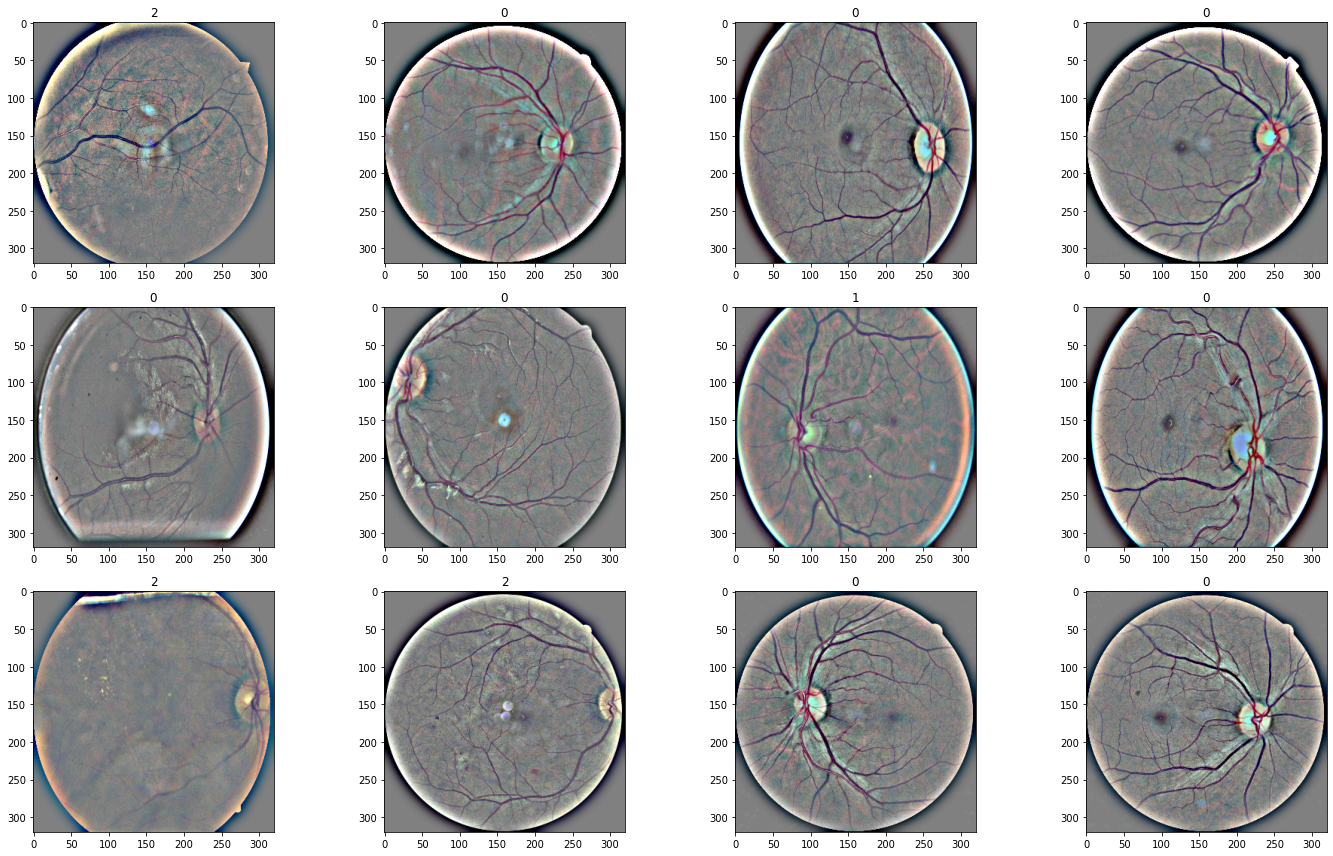

In [ ]:
%cd /gdrive/My Drive/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'image']
        image_id = df.loc[i,'level']
        img = cv2.imread(f'{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = crop_image_from_gray(img)
        img = cv2.resize(img, (im_size,im_size))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), im_size/40) ,-4 ,128)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Processing Images

__UPDATE:__ Here we are reading just the validation set. In order to use 320x320 images, we are going to load one bucket at a time only when needed. This will let our code run without memory-related errors.

In [ ]:
# validation set
N = val_df.shape[0]
x_val = np.empty((N, im_size, im_size, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm_notebook(val_df['image'])):
    x_val[i, :, :, :] = preprocess_image(
        f'{image_id}',
        desired_size = im_size
    )

In [ ]:
y_train = pd.get_dummies(train_df['level']).values
y_val = pd.get_dummies(val_df['level']).values

print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(10500, 5)
(4500, 320, 320, 3)
(4500, 5)


# Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [ ]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

y_val_multi = np.empty(y_val.shape, dtype=y_val.dtype)
y_val_multi[:, 4] = y_val[:, 4]

for i in range(3, -1, -1):
    y_val_multi[:, i] = np.logical_or(y_val[:, i], y_val_multi[:, i+1])

print("Y_train multi: {}".format(y_train_multi.shape))
print("Y_val multi: {}".format(y_val_multi.shape))

Y_train multi: (10500, 5)
Y_val multi: (4500, 5)


In [ ]:
y_train = y_train_multi
y_val = y_val_multi

# Creating keras callback for QWK

---

I had to change this function, in order to consider the best kappa score among all the buckets.

In [ ]:
class Metrics(Callback):

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('denseNet_5_all.h5')

        return

# Data Generator

In [ ]:
def create_datagen():
    return ImageDataGenerator(
        featurewise_std_normalization = True,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 360
    )

# Model: DenseNet-121

In [ ]:
densenet = DenseNet121(
    weights='/gdrive/My Drive/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(im_size,im_size,3)
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.0001,decay=1e-6),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
model = build_model()
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


# Training & Evaluation

In [ ]:
#train_df = train_df.reset_index(drop=True)
bucket_num = 8
# bucket_num = 3
div = round(train_df.shape[0]/bucket_num)

In [ ]:
df_init = {
    'val_loss': [0.0],
    'val_accuracy': [0.0],
    'loss': [0.0], 
    'accuracy': [0.0],
    'bucket': [0.0]
}
results = pd.DataFrame(df_init)

In [ ]:
# I found that changing the nr. of epochs for each bucket helped in terms of performances
epochs = [5,5,10,15,15,20,20,30]
# epochs = [5,5,10]
kappa_metrics = Metrics()
kappa_metrics.val_kappas = []

In [ ]:
for i in range(0,bucket_num):
    if i != (bucket_num-1):
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:(1+i)*div].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:(1+i)*div,0])):
            x_train[j, :, :, :] = preprocess_image(f'{image_id}', desired_size = im_size)

        data_generator = create_datagen().flow(x_train, y_train[i*div:(1+i)*div,:], batch_size=BATCH_SIZE)
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i
    else:
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:,0])):
            x_train[j, :, :, :] = preprocess_image(f'{image_id}', desired_size = im_size)
        data_generator = create_datagen().flow(x_train, y_train[i*div:,:], batch_size=BATCH_SIZE)
        
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i

    results = results.append(df_model)
    
    del data_generator
    del x_train
    gc.collect()
    
    print('-'*40)

Bucket Nr: 0


Epoch 1/5
66/65 [==============================] - 196s 3s/step - loss: 0.5869 - accuracy: 0.7262 - val_loss: 1.3327 - val_accuracy: 0.5299
val_kappa: 0.0449
Validation Kappa has improved. Saving model.
Epoch 2/5
66/65 [==============================] - 142s 2s/step - loss: 0.2954 - accuracy: 0.8854 - val_loss: 0.4747 - val_accuracy: 0.7725
val_kappa: 0.2717
Validation Kappa has improved. Saving model.
Epoch 3/5
66/65 [==============================] - 142s 2s/step - loss: 0.2539 - accuracy: 0.9032 - val_loss: 0.2906 - val_accuracy: 0.8950
val_kappa: 0.5368
Validation Kappa has improved. Saving model.
Epoch 4/5
66/65 [==============================] - 142s 2s/step - loss: 0.2311 - accuracy: 0.9085 - val_loss: 0.2242 - val_accuracy: 0.9165
val_kappa: 0.4164
Epoch 5/5
66/65 [==============================] - 141s 2s/step - loss: 0.2015 - accuracy: 0.9247 - val_loss: 0.2594 - val_accuracy: 0.8900
val_kappa: 0.5396
Validation Kappa has improved. Saving model.
------------------------------


Epoch 1/5
66/65 [==============================] - 142s 2s/step - loss: 0.2278 - accuracy: 0.9096 - val_loss: 0.3385 - val_accuracy: 0.8343
val_kappa: 0.3696
Epoch 2/5
66/65 [==============================] - 141s 2s/step - loss: 0.1975 - accuracy: 0.9259 - val_loss: 0.1826 - val_accuracy: 0.9298
val_kappa: 0.5527
Validation Kappa has improved. Saving model.
Epoch 3/5
66/65 [==============================] - 141s 2s/step - loss: 0.1838 - accuracy: 0.9305 - val_loss: 0.1900 - val_accuracy: 0.9302
val_kappa: 0.5763
Validation Kappa has improved. Saving model.
Epoch 4/5
66/65 [==============================] - 142s 2s/step - loss: 0.1652 - accuracy: 0.9352 - val_loss: 0.1777 - val_accuracy: 0.9324
val_kappa: 0.6146
Validation Kappa has improved. Saving model.
Epoch 5/5
66/65 [==============================] - 143s 2s/step - loss: 0.1581 - accuracy: 0.9357 - val_loss: 0.1943 - val_accuracy: 0.9179
val_kappa: 0.6089
----------------------------------------
Bucket Nr: 2



Epoch 1/10
66/65 [==============================] - 142s 2s/step - loss: 0.2013 - accuracy: 0.9233 - val_loss: 0.1882 - val_accuracy: 0.9300
val_kappa: 0.5596
Epoch 2/10
66/65 [==============================] - 142s 2s/step - loss: 0.1840 - accuracy: 0.9267 - val_loss: 0.2062 - val_accuracy: 0.9260
val_kappa: 0.4863
Epoch 3/10
66/65 [==============================] - 141s 2s/step - loss: 0.1642 - accuracy: 0.9370 - val_loss: 0.1853 - val_accuracy: 0.9311
val_kappa: 0.5881
Epoch 4/10
66/65 [==============================] - 141s 2s/step - loss: 0.1616 - accuracy: 0.9354 - val_loss: 0.2238 - val_accuracy: 0.9320
val_kappa: 0.5900
Epoch 5/10
66/65 [==============================] - 141s 2s/step - loss: 0.1512 - accuracy: 0.9436 - val_loss: 0.2240 - val_accuracy: 0.9295
val_kappa: 0.5333
Epoch 6/10
66/65 [==============================] - 141s 2s/step - loss: 0.1418 - accuracy: 0.9442 - val_loss: 0.2990 - val_accuracy: 0.9200
val_kappa: 0.4121
Epoch 7/10
66/65 [===========================


Epoch 1/15
66/65 [==============================] - 143s 2s/step - loss: 0.2026 - accuracy: 0.9248 - val_loss: 0.1825 - val_accuracy: 0.9358
val_kappa: 0.6430
Validation Kappa has improved. Saving model.
Epoch 2/15
66/65 [==============================] - 141s 2s/step - loss: 0.1710 - accuracy: 0.9357 - val_loss: 0.1947 - val_accuracy: 0.9347
val_kappa: 0.5903
Epoch 3/15
66/65 [==============================] - 141s 2s/step - loss: 0.1588 - accuracy: 0.9377 - val_loss: 0.1675 - val_accuracy: 0.9353
val_kappa: 0.6781
Validation Kappa has improved. Saving model.
Epoch 4/15
66/65 [==============================] - 141s 2s/step - loss: 0.1548 - accuracy: 0.9389 - val_loss: 0.1649 - val_accuracy: 0.9387
val_kappa: 0.6929
Validation Kappa has improved. Saving model.
Epoch 5/15
66/65 [==============================] - 141s 2s/step - loss: 0.1481 - accuracy: 0.9430 - val_loss: 0.1715 - val_accuracy: 0.9370
val_kappa: 0.6626
Epoch 6/15
66/65 [==============================] - 141s 2s/step - lo


Epoch 1/15
66/65 [==============================] - 142s 2s/step - loss: 0.1992 - accuracy: 0.9259 - val_loss: 0.2256 - val_accuracy: 0.9137
val_kappa: 0.6141
Epoch 2/15
66/65 [==============================] - 141s 2s/step - loss: 0.1544 - accuracy: 0.9407 - val_loss: 0.2021 - val_accuracy: 0.9374
val_kappa: 0.6464
Epoch 3/15
66/65 [==============================] - 141s 2s/step - loss: 0.1377 - accuracy: 0.9470 - val_loss: 0.2190 - val_accuracy: 0.9342
val_kappa: 0.5964
Epoch 4/15
66/65 [==============================] - 141s 2s/step - loss: 0.1363 - accuracy: 0.9476 - val_loss: 0.2186 - val_accuracy: 0.9364
val_kappa: 0.6157
Epoch 5/15
66/65 [==============================] - 141s 2s/step - loss: 0.1279 - accuracy: 0.9502 - val_loss: 0.2206 - val_accuracy: 0.9358
val_kappa: 0.5957
Epoch 6/15
66/65 [==============================] - 142s 2s/step - loss: 0.1202 - accuracy: 0.9546 - val_loss: 0.2542 - val_accuracy: 0.9352
val_kappa: 0.5931
Epoch 7/15
66/65 [===========================


Epoch 1/20
66/65 [==============================] - 142s 2s/step - loss: 0.2102 - accuracy: 0.9262 - val_loss: 0.2653 - val_accuracy: 0.9348
val_kappa: 0.6082
Epoch 2/20
66/65 [==============================] - 141s 2s/step - loss: 0.1613 - accuracy: 0.9380 - val_loss: 0.1864 - val_accuracy: 0.9400
val_kappa: 0.6639
Epoch 3/20
66/65 [==============================] - 142s 2s/step - loss: 0.1481 - accuracy: 0.9450 - val_loss: 0.1884 - val_accuracy: 0.9294
val_kappa: 0.6252
Epoch 4/20
66/65 [==============================] - 140s 2s/step - loss: 0.1439 - accuracy: 0.9419 - val_loss: 0.3268 - val_accuracy: 0.9269
val_kappa: 0.5061
Epoch 5/20
66/65 [==============================] - 140s 2s/step - loss: 0.1312 - accuracy: 0.9488 - val_loss: 0.1954 - val_accuracy: 0.9401
val_kappa: 0.6890
Epoch 6/20
66/65 [==============================] - 140s 2s/step - loss: 0.1182 - accuracy: 0.9534 - val_loss: 0.2644 - val_accuracy: 0.9320
val_kappa: 0.5674
Epoch 7/20
66/65 [===========================


Epoch 1/20
66/65 [==============================] - 140s 2s/step - loss: 0.2214 - accuracy: 0.9264 - val_loss: 0.3393 - val_accuracy: 0.9283
val_kappa: 0.5245
Epoch 2/20
66/65 [==============================] - 139s 2s/step - loss: 0.1618 - accuracy: 0.9357 - val_loss: 0.2563 - val_accuracy: 0.9283
val_kappa: 0.5598
Epoch 3/20
66/65 [==============================] - 142s 2s/step - loss: 0.1418 - accuracy: 0.9459 - val_loss: 0.1908 - val_accuracy: 0.9403
val_kappa: 0.6353
Epoch 4/20
66/65 [==============================] - 141s 2s/step - loss: 0.1247 - accuracy: 0.9512 - val_loss: 0.1626 - val_accuracy: 0.9412
val_kappa: 0.6962
Epoch 5/20
66/65 [==============================] - 141s 2s/step - loss: 0.1230 - accuracy: 0.9524 - val_loss: 0.1816 - val_accuracy: 0.9406
val_kappa: 0.6765
Epoch 6/20
66/65 [==============================] - 141s 2s/step - loss: 0.1164 - accuracy: 0.9553 - val_loss: 0.1786 - val_accuracy: 0.9331
val_kappa: 0.6576
Epoch 7/20
66/65 [===========================


Epoch 1/30
66/65 [==============================] - 147s 2s/step - loss: 0.2316 - accuracy: 0.9274 - val_loss: 0.9779 - val_accuracy: 0.9116
val_kappa: 0.2662
Epoch 2/30
66/65 [==============================] - 141s 2s/step - loss: 0.1644 - accuracy: 0.9388 - val_loss: 0.1958 - val_accuracy: 0.9404
val_kappa: 0.6861
Epoch 3/30
66/65 [==============================] - 141s 2s/step - loss: 0.1472 - accuracy: 0.9444 - val_loss: 0.1775 - val_accuracy: 0.9280
val_kappa: 0.6920
Epoch 4/30
66/65 [==============================] - 141s 2s/step - loss: 0.1313 - accuracy: 0.9524 - val_loss: 0.1614 - val_accuracy: 0.9372
val_kappa: 0.7290
Validation Kappa has improved. Saving model.
Epoch 5/30
66/65 [==============================] - 142s 2s/step - loss: 0.1278 - accuracy: 0.9515 - val_loss: 0.1759 - val_accuracy: 0.9286
val_kappa: 0.7038
Epoch 6/30
66/65 [==============================] - 141s 2s/step - loss: 0.1150 - accuracy: 0.9570 - val_loss: 0.1761 - val_accuracy: 0.9423
val_kappa: 0.7066


In [ ]:
results = results.iloc[1:]
results['kappa'] = kappa_metrics.val_kappas
results = results.reset_index()
results = results.rename(index=str, columns={"index": "epoch"})
results

,epoch,val_loss,val_accuracy,loss,accuracy,bucket,kappa
0,0,1.332724,0.529911,0.588526,0.726219,0.0,0.044949
1,1,0.474651,0.772533,0.296255,0.885366,0.0,0.271743
2,2,0.290634,0.894978,0.254473,0.903201,0.0,0.536769
3,3,0.224171,0.916489,0.230301,0.908537,0.0,0.416390
4,4,0.259405,0.890000,0.201761,0.924695,0.0,0.539594
...,...,...,...,...,...,...,...
115,25,0.264934,0.933911,0.034370,0.988450,7.0,0.678407
116,26,0.287161,0.918578,0.040714,0.983891,7.0,0.647563
117,27,0.270520,0.929644,0.037510,0.986474,7.0,0.702871
118,28,0.249301,0.938000,0.028744,0.989362,7.0,0.703629


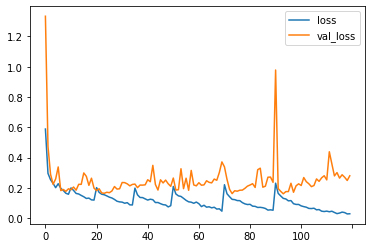

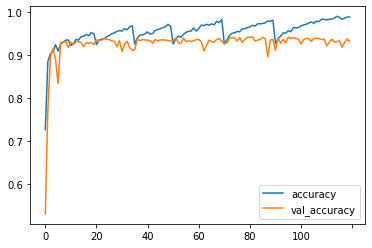

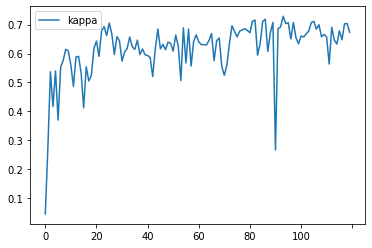

In [ ]:
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()
results[['kappa']].plot()
results.to_csv('results_5_all.csv',index=False)

# Find best threshold

In [ ]:
model.load_weights('denseNet_5_all.h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]

y1 = y_val_pred > best_threshold
y1 = y1.astype(int).sum(axis=1) - 1
y2 = y_val.sum(axis=1) - 1
score = cohen_kappa_score(y1, y2, weights='quadratic')
print('Threshold: {}'.format(best_threshold))
print('Validation QWK score with best_threshold: {}'.format(score))

y1 = y_val_pred > .5
y1 = y1.astype(int).sum(axis=1) - 1
score = cohen_kappa_score(y1, y2, weights='quadratic')
print('Validation QWK score with .5 threshold: {}'.format(score))

Threshold: 0.5271484375
Validation QWK score with best_threshold: 0.733341729625192
Validation QWK score with .5 threshold: 0.7289761816956395


In [ ]:
%mv denseNet_5_all.h5 results_5_all.csv ../

In [ ]:
y_best = y_val_pred > best_threshold
y_best  = y_best .astype(int).sum(axis=1) - 1
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_best, y2))
print('Classification Report')
target_names = ['No DR', 'Mild', 'Moderate','Severe','Poliferative']
print(classification_report(y_best, y2, target_names=target_names))

Confusion Matrix
[[3092  231  191    8    5]
 [ 101   45   48    1    0]
 [ 110   29  307   37   19]
 [   5    1   90   63   15]
 [  10    1   22   20   49]]
Classification Report
              precision    recall  f1-score   support

       No DR       0.93      0.88      0.90      3527
        Mild       0.15      0.23      0.18       195
    Moderate       0.47      0.61      0.53       502
      Severe       0.49      0.36      0.42       174
Poliferative       0.56      0.48      0.52       102

    accuracy                           0.79      4500
   macro avg       0.52      0.51      0.51      4500
weighted avg       0.82      0.79      0.80      4500



In [ ]:
# score = model.evaluate(x_val, Y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# Inference Kernel

https://www.kaggle.com/raimonds1993/aptos19-densenet-trained-with-old-and-new-data
